### XGBoost – Fold-Based Evaluation

This notebook evaluates the **XGBoost Regressor** using a consistent fold-based semi-supervised strategy across 8 predefined folds.

### Experiment Design

- Each `.arff` fold contains a time-based segment of wind turbine data.
- For each fold:
  - A random pool of **2000 samples** is extracted.
  - A percentage (1%, 5%, 10%) is used as the labeled training set.
  - The remaining samples in the fold are used for testing.
- **Hyperparameters** are tuned via `GridSearchCV`.


This setup enables fair comparison with other models like ElasticNet and S2RMS under identical conditions.


In [8]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.io import arff

sns.set_theme(style="whitegrid")

In [9]:
DATA_DIR = "../data/swdpf/arff_folds"
RESULTS_DIR = "../results/xgboost_folds"
os.makedirs(RESULTS_DIR, exist_ok=True)

SCALES = [0.1, 0.2, 0.3]
FOLDS = range(8)
TARGET_COL = "patv_target_1"

In [10]:
def evaluate_xgboost_on_fold(data, scale, fold):
    pool = data.sample(2000, random_state=fold)
    labeled = pool.sample(int(2000 * scale), random_state=fold)
    test = data.drop(pool.index)

    X_train = labeled.drop(columns=[TARGET_COL])
    y_train = labeled[TARGET_COL]

    X_test = test.drop(columns=[TARGET_COL])
    y_test = test[TARGET_COL]

    model = XGBRegressor(objective='reg:squarederror', random_state=fold)

    param_grid = {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 6],
        'subsample': [0.8],
        'colsample_bytree': [0.8]
    }

    grid_search = GridSearchCV(
        model,
        param_grid=param_grid,
        scoring='neg_mean_absolute_error',
        cv=5,
        n_jobs=-1,
        verbose=0
    )
    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)

    scaler_y_path = os.path.join(DATA_DIR, f"scaler_y_fold{fold}.joblib")
    scaler_y = joblib.load(scaler_y_path)

    y_test_denorm = scaler_y.inverse_transform(y_test.values.reshape(-1, 1)).ravel()
    y_pred_denorm = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).ravel()

    rmse = np.sqrt(mean_squared_error(y_test_denorm, y_pred_denorm))
    mae = mean_absolute_error(y_test_denorm, y_pred_denorm)
    rse = np.sum((y_test_denorm - y_pred_denorm) ** 2) / np.sum((y_test_denorm - np.mean(y_test_denorm)) ** 2)
    r2 = r2_score(y_test_denorm, y_pred_denorm)

    return {
        "fold": fold,
        "scale": scale,
        "rmse": rmse,
        "mae": mae,
        "rse": rse,
        "r2": r2,
        "best_params": grid_search.best_params_
    }

In [11]:
results = []

for fold in FOLDS:
    arff_path = os.path.join(DATA_DIR, f"fold{fold}.arff")
    data, _ = arff.loadarff(arff_path)
    df = pd.DataFrame(data)

    for scale in SCALES:
        print(f"Fold {fold} | Scale {scale}")
        metrics = evaluate_xgboost_on_fold(df, scale, fold)
        results.append(metrics)

Fold 0 | Scale 0.1
Fold 0 | Scale 0.2
Fold 0 | Scale 0.3
Fold 1 | Scale 0.1
Fold 1 | Scale 0.2
Fold 1 | Scale 0.3
Fold 2 | Scale 0.1
Fold 2 | Scale 0.2
Fold 2 | Scale 0.3
Fold 3 | Scale 0.1
Fold 3 | Scale 0.2
Fold 3 | Scale 0.3
Fold 4 | Scale 0.1
Fold 4 | Scale 0.2
Fold 4 | Scale 0.3
Fold 5 | Scale 0.1
Fold 5 | Scale 0.2
Fold 5 | Scale 0.3
Fold 6 | Scale 0.1
Fold 6 | Scale 0.2
Fold 6 | Scale 0.3
Fold 7 | Scale 0.1
Fold 7 | Scale 0.2
Fold 7 | Scale 0.3


In [12]:
results_df = pd.DataFrame(results)
results_df.to_csv(os.path.join(RESULTS_DIR, "xgboost_fold_results.csv"), index=False)

print("Results saved to:", os.path.join(RESULTS_DIR, "xgboost_fold_results.csv"))
display(results_df)

Results saved to: ../results/xgboost_folds\xgboost_fold_results.csv


,fold,scale,rmse,mae,rse,r2,best_params
0,0,0.1,143.835725,89.976778,0.126268,0.873732,"{'colsample_bytree': 0.8, 'learning_rate': 0.1..."
1,0,0.2,141.075615,86.181977,0.121468,0.878532,"{'colsample_bytree': 0.8, 'learning_rate': 0.1..."
2,0,0.3,140.354371,85.423336,0.120230,0.879770,"{'colsample_bytree': 0.8, 'learning_rate': 0.1..."
3,1,0.1,115.427343,69.635871,0.079122,0.920878,"{'colsample_bytree': 0.8, 'learning_rate': 0.1..."
4,1,0.2,112.190705,65.397572,0.074747,0.925253,"{'colsample_bytree': 0.8, 'learning_rate': 0.1..."
5,1,0.3,108.048691,62.162600,0.069329,0.930671,"{'colsample_bytree': 0.8, 'learning_rate': 0.1..."
6,2,0.1,89.049551,49.804437,0.053825,0.946175,"{'colsample_bytree': 0.8, 'learning_rate': 0.1..."
7,2,0.2,80.455491,45.032131,0.043937,0.956063,"{'colsample_bytree': 0.8, 'learning_rate': 0.1..."
8,2,0.3,77.634533,43.342442,0.040910,0.959090,"{'colsample_bytree': 0.8, 'learning_rate': 0.1..."
9,3,0.1,98.780360,54.767782,0.048802,0.951198,"{'colsample_bytree': 0.8, 'learning_rate': 0.1..."


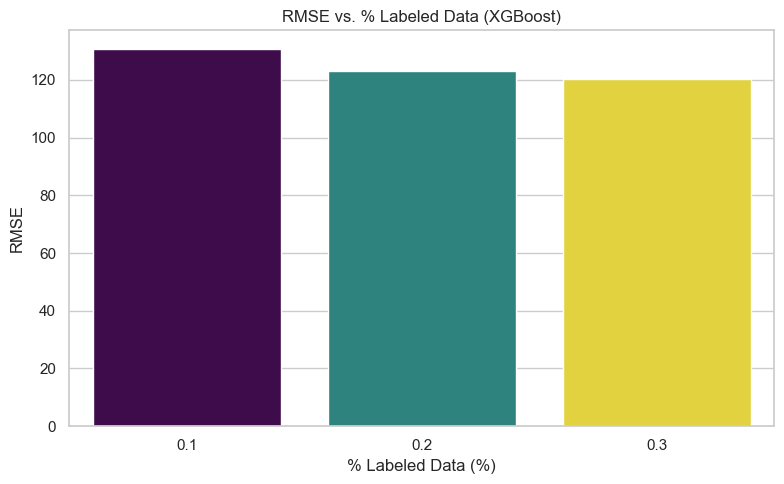

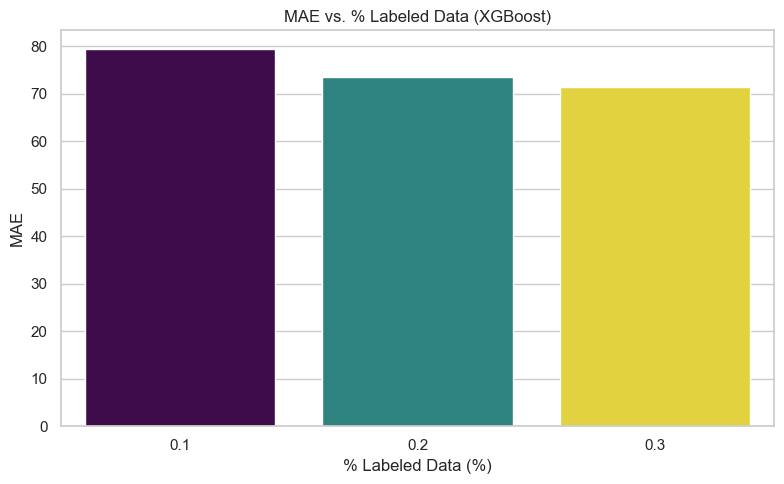

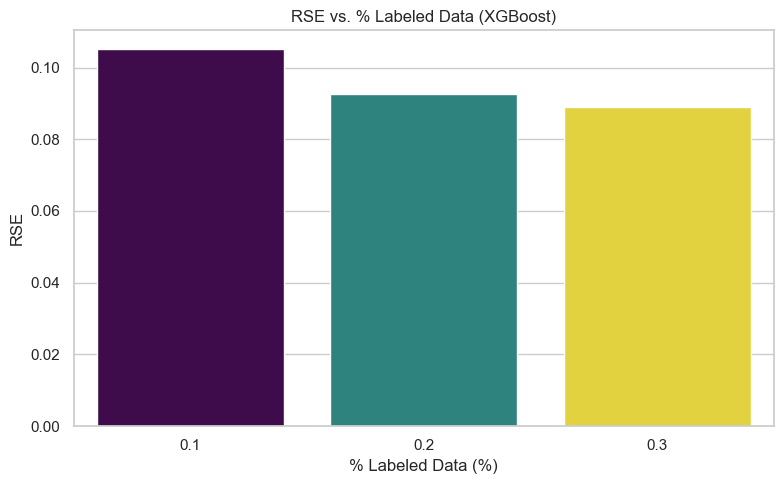

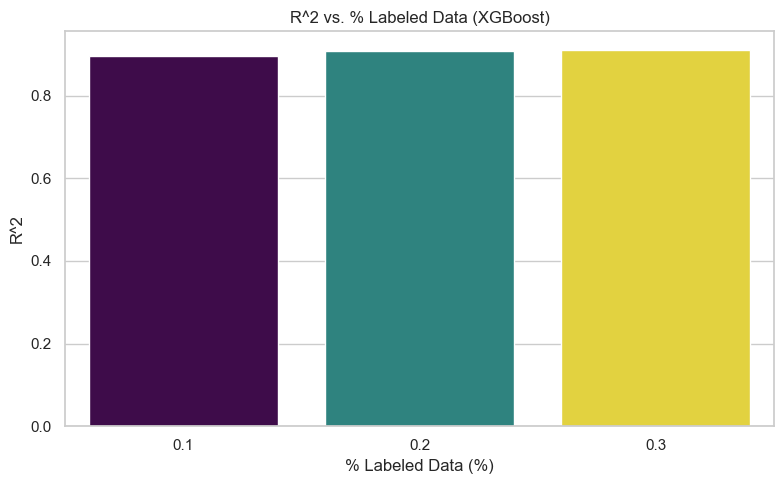

In [13]:
summary_df = results_df.groupby("scale").agg(
    rmse_mean=("rmse", "mean"),
    rmse_std=("rmse", "std"),
    mae_mean=("mae", "mean"),
    mae_std=("mae", "std"),
    rse_mean=("rse", "mean"),
    rse_std=("rse", "std"),
    r2_mean=("r2", "mean"),
    r2_std=("r2", "std")
).reset_index()

def plot_metric(df, metric, ylabel):
    plt.figure(figsize=(8, 5))
    sns.barplot(
        x="scale",
        y=f"{metric}_mean",
        hue="scale",
        data=df,
        palette="viridis",
        legend=False
    )
    plt.ylabel(ylabel)
    plt.title(f"{ylabel} vs. % Labeled Data (XGBoost)")
    plt.xlabel("% Labeled Data (%)")
    plt.tight_layout()
    plt.show()

plot_metric(summary_df, "rmse", "RMSE")
plot_metric(summary_df, "mae", "MAE")
plot_metric(summary_df, "rse", "RSE")
plot_metric(summary_df, "r2", "R^2")